# Prelab 5 Life in the Phase Plane

> Yujia, Ethan, and Vincent adapted from materials developed by Diane and Elizabeth
> 
> 2024/4/25 (Week 6)

Edit this document directly. As you go through the notebooks you will find numbered questions. Please answer in the cells provided. 
   
This is an individual assignment, but you are allowed (encouraged!) to work together in groups and discuss coding and
answers. That said, you are responsible for all the material in this laboratory assignment. **DO NOT
COPY from anyone that you work with.** You are **NOT** allowed to share code. You need to write the code
and answer the questions yourself. Try the coding yourself first before seeking help.

<div class="alert alert-info" role="alert">

Please rename your notebook to `Lastname_Firstname_prelab#` and export it as HTML for submission

__Total Points 7__

__Due: 4/25 Thursday 1:30 pm (week 6)__ 
</div> 

If you have any questions, please do not hesitate to ask. You can find the emails and office hours of your instructors and TAs on Canvas. Best of luck!

Feel free to go to the Quantitative Biosciences Center for help! 
[https://college.uchicago.edu/academics/quantitative-biosciences-center](https://college.uchicago.edu/academics/quantitative-biosciences-center) 

<!--
<div class="alert alert-warning" role="alert">   

    
**Grading Notes**
    
Each section (1.1,1.2, etc.) is worth one point. Guideline for point assignment:   
        1 - everything is correct (or approach is correct but previous part had an error)   
        .75 - small syntax errors   
        .5 - mostly right   
        .25 - made an attempt    
        0 - no attempt
   
       
**1.1**  
1 pt for RHS equation  
1 pt for XRHS function   
1 pt for YRHS function   
1 pt for flow field   
1 pt for each null cline   
1 pt for using odeint   
1 pt for plotting x,y on the phase plane   
1 pt for x vs t plot   
1 pt for y vs t plot   
1 pt for looping over initial conditions
</div>   
-->



## Part 1 Vector Field, Nullclines, and Trajectories in the Phase Plane

2D systems (i.e. the ones with two state variables like $X$ and $Y$) open doors for dynamics that are _not possible_ in 1D including oscillations and pulses.
__Phase plane analysis__ is a useful tool to understand the dynamics of 2D systems. 
It (in some way) is an extension to the flux balance analysis that we're familiar with in 1D.
If your state variables are called $X$ and $Y$, your phase plane is simply the X-Y plane.

In this prelab you will learn how to plot a few objects that live in the phase plane including the vector field, nullclines, and trajectories using Python.

I'll walk you through the technique using the following toy model. In this toy model, $X$ is simply regulated and $Y$ is repressed by $X$. The system admits a single stable steady state. In other words, the steady state you'll find here is _globally stable_

$$
\begin{align}
\frac{dX}{dt} &= \beta_X - \alpha_X X\\
\frac{dY}{dt} &= \beta_Y\frac{K^n}{K^n + X^n} - \alpha_Y Y
\end{align}
$$

First let's write down a right-hand side function of the ODE and give some parameters

In [1]:
def rhs_toy(u, t, betaX, alphaX, betaY, K, n, alphaY):
    X, Y = u
    dXdt = betaX - alphaX*X
    dYdt = betaY*K**n/(K**n + X**n) - alphaY*Y
    return dXdt, dYdt

betaX = 1
alphaX = 1
betaY = 2
alphaY = 1
K = 2
n = 6

### Vector Field

We will use `pyplot.quiver` function which plots a 2D field of arrows [(more about it)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html).
The "arrows" are derivatives evaluated at different positions on the X-Y plane.
To get the derivatives, we will begin with the input as a grid of $(X, Y)$ and 
use your RHS function to get the output as a grid of $(dX/dt, dY/dt)$.
The task should remind you of making a 3D plot because,
to do that, you will also start by constructing an $(X, Y)$ grid.

Just to spell out the syntax

```python
pyplot.quiver(X, Y, dXdt, dYdt)
```

With that, the goal here is to first use `numpy.meshgrid` to construct an X-Y grid.
Then, with the help of the RHS defined above, we can calculate the derivatives of $X$ and $Y$ at each grid point.
Finally, we will use `quiver` to plot arrows representing this field of derivatives.
The field of derivatives is called a __vector field__.

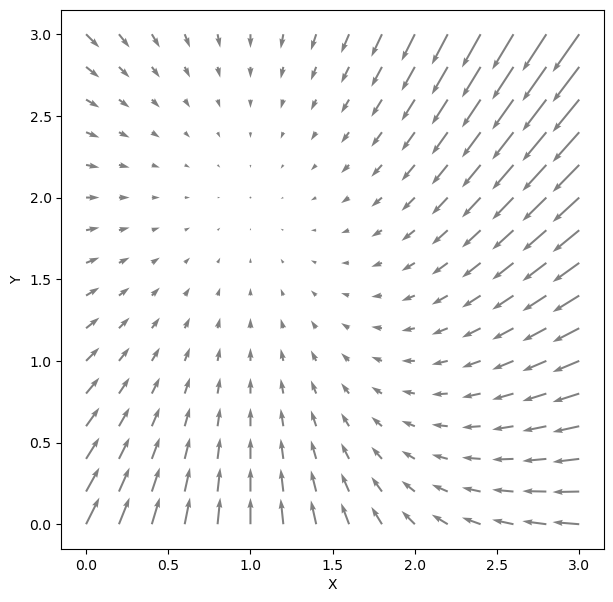

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# First, construct a grid of X and Y
X_vec = np.linspace(0, 3, 16)
Y_vec = np.linspace(0, 3, 16)
X, Y = np.meshgrid(X_vec, Y_vec)

# Then, calculate the derivatives using the combinations of X and Y values
# the RHS doesn't involve so it doesn't matter what t we pass to the function
dXdt, dYdt = rhs_toy([X, Y], None, betaX, alphaX, betaY, K, n, alphaY)

# Plot
p, ax = plt.subplots(figsize=(7, 7))
ax.quiver(X, Y, dXdt, dYdt, color="gray")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

### Nullclines

Nullclines are curves where either $dX/dt$ or $dY/dt$ is 0.
Nullclines can provide useful intuition about the system.
E.g. the intersections of the nullclines are the steady states
and the derivative arrows can only change its horizontal directions when crossing the X-nullcline (given that RHS is continuous)

We will use the `pyplot.contour` function [(more about it)](https://matplotlib.org/stable/api/contour_api.html#module-matplotlib.contour) to find and plot the nullclines.
The `contour` function uses a field of derivatives (which we already calculated in the above cell) and find where the derivative should be the closest to 0. Try it out!

```python
pyplot.contour(X, Y, derivative, levels)
```

Here levels will simply be `[0]` because, by definition, a nullcline is a curve where the derivatives are 0.

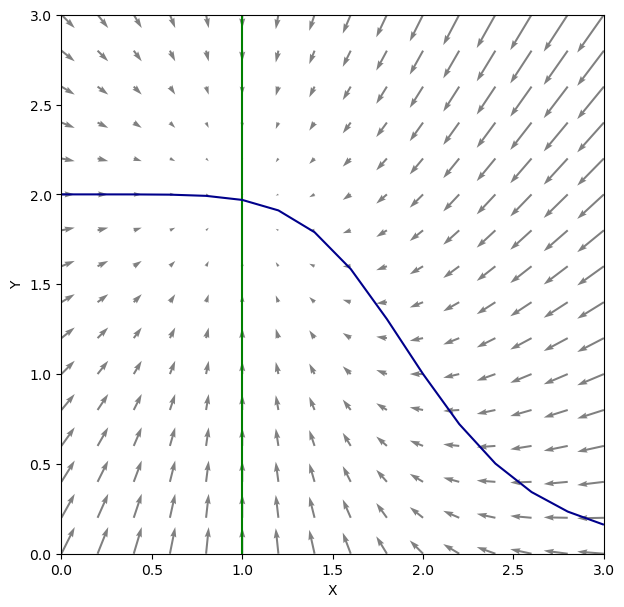

In [3]:
# we're going to overlay the nullclines on the vector field
# X-nullcline
ax.contour(X, Y, dXdt, [0], colors=["green"])

# Y-nullcline
ax.contour(X, Y, dYdt, [0], colors=["darkblue"])
p

### Trajectory

A vector field is very useful because we can use it to roughly predict how a system would evolve given that it starts somewhere in the phase plane.

To convince yourself that this is true, we will get the solution to the system by `odeint` and plot it in the phase plane.
By doing that you will lose the _time_ information, but the vector space should give you a direction of time.

We will then use a helper function called `my_axes` to plot the time-domain traces side-by-side with those in the phase plane.
Run the cell below to define this helper function

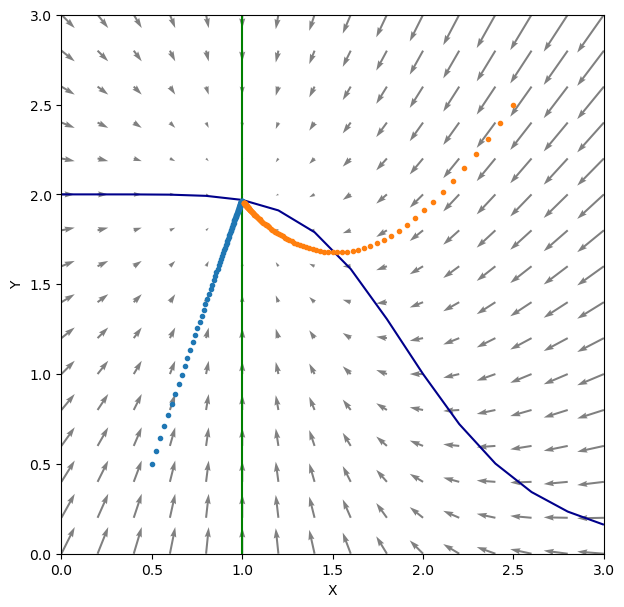

In [4]:
from scipy.integrate import odeint

# Initial values
XY0_vec = [[0.5, 0.5], [2.5, 2.5]]

# Time span
tspan = np.linspace(0, 5, 101)

# Parameters
args = (betaX, alphaX, betaY, K, n, alphaY)

# Integrate and plot
for X0, Y0 in XY0_vec:
    sol = odeint(rhs_toy, [X0, Y0], tspan, args)
    ax.plot(sol[:, 0], sol[:, 1], '.')

p

In [5]:
from matplotlib import pyplot as plt

def my_axes(figsize=(9, 9)):
    
    p, ax = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'height_ratios': (3, 1),'width_ratios': (3, 1)},
                        sharex="col", sharey="row")

    # axis labels
    ax[0][0].set_xlabel("")
    ax[0][0].set_ylabel("")

    ax[0][1].set_ylabel("[Y]", rotation=0, labelpad=10.)
    ax[0][1].yaxis.set_label_position("right")
    ax[1][0].set_xlabel("[X]")
    ax[0][1].set_xlabel("Time")
    ax[0][1].xaxis.set_label_position("top")
    ax[1][0].set_ylabel("Time")

    # invert time of the bottom graph
    ax[1][0].invert_yaxis()

    # nothing on the bottom right
    ax[1][1].axis("off")

    # orient the axes
    ax[0][0].tick_params(axis="x", labeltop=True, bottom=False, top=True)
    ax[0][1].tick_params(axis="x", labeltop=True, bottom=False, top=True)
    ax[0][1].tick_params(axis="y", labelright=True, left=False, right=True)

    # reduce padding
    p.subplots_adjust(wspace=0.1, hspace=0.1)

    return p, ax

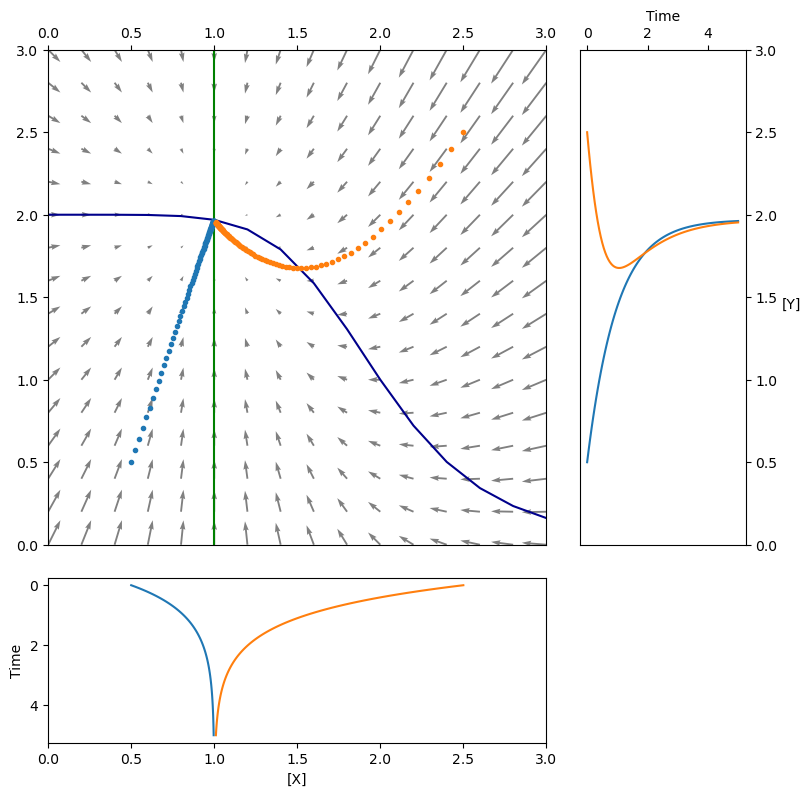

In [6]:
p, axes = my_axes()

axes[0][0].quiver(X, Y, dXdt, dYdt, color="gray")

axes[0][0].contour(X, Y, dXdt, [0], colors=["green"])
axes[0][0].contour(X, Y, dYdt, [0], colors=["darkblue"])

for X0, Y0 in XY0_vec:
    sol = odeint(rhs_toy, [X0, Y0], tspan, args)
    
    axes[0][0].plot(sol[:, 0], sol[:, 1], '.')
    
    axes[0][1].plot(tspan, sol[:, 1])
    axes[1][0].plot(sol[:, 0], tspan)

plt.show()

## Part 2 Practice: the Bistable Switch 

It's time to hone your skills of phase plane analysis!
Consider the double-positive loop we studied in class:


<img src="https://github.com/dschnitkey/BIOS20236/blob/main/pospos%20circuit.png?raw=true" alt= “” width="300">

$$
\begin{align}
\frac{dX}{dt} &= \beta_x \frac{Y^n}{Y^n + K_x^n} - \alpha _x X\\
\frac{dy}{dt} &= \beta_y \frac{X^m}{X^m + K_y^m} - \alpha _y Y
\end{align}
$$

<h3 style="color:blue;">Tasks for Part 2</h3>

__2.1__ Define the RHS function. Keep in mind that the state variable is 2D and the return value, i.e. the derivative, is also 2D

In [18]:
# your solution 2.1



__2.2 The Vector Field.__ Use the RHS function you've defined above to calculate a field of derivatives with $X$ ranging from 0 to 3 and $Y$ ranging from 0 to 3.

Plot the field of derivatives with the `quiver` function. Try not to make your grid too dense. If the grid is too dense, the arrows may clash with their neighbors and make the plot a mess. 10 to 20 grid points per dimension is usually a good idea. Make your arrows gray - I feel that'll make it easier to distinguish the arrows from other objects in the phase plane.

Please use the following parameters

$$
\begin{align}
\beta_X &= \beta_Y = 2\\
\alpha_X &= \alpha_Y = 1\\
K_X &= 0.8\\
K_Y &= 1\\
n &= 4\\
m &= 6
\end{align}
$$

In [17]:
# your solution 2.2



__2.3 The nullclines.__ Plot the X- and Y-nullclines in a new plot. You don't have to overlay it on top of the vector field. A later question will ask you to put everything together.

Recall that nullclines are curves where the derivative of either $X$ or $Y$ is 0.
Since here we find the nullclines numerically, the denser grid of $X$ and $Y$, the smoother your nullclines will be.
E.g., If you have calculated the vector field with 10 grid points along $X$ and 10 grid points along $Y$ by the following Python commands

```python
X_vec = np.linspace(0, 3, 10)
Y_vec = np.linspace(0, 3, 10)
X, Y = np.meshgrid(X_vec, Y_vec)
```

__In this question you should start with a denser grid than the vector field you made in 2.2.__ E.g. you can try 100 grid points along $X$ and $Y$:

```python
X2_vec = np.linspace(0, 3, 100)
Y2_vec = np.linspace(0, 3, 100)
X2, Y2 = np.meshgrid(X2_vec, Y2_vec)
```

Then, calculate a field of derivatives with the RHS function and the denser grid you've created.
Finally, find and plot the nullclines using the function `contour`. You should pass the denser field of derivatives to your `contour`.
Please use two different colors for your X- and Y-nullclines

In [16]:
# your solution 2.3



__2.4 Trajectory.__ Integrate the 2D ODE using `odeint` with initial condition $X_0 = 0.5,\;Y_0 = 1.5$. 
Use time span from 0 to 10.
Make a new figure and __plot the solution in the phase plane__.
Limit the X- and Y-axis of the figure between 0 and 3.


In [15]:
# your solution 2.4



__2.5 The Phase Portrait.__ It's time to put everything together! First, use the helper function `my_axes` to create a new figure.
The new figure will have three panels: The top-left one is the phase plane. The top-right one is for $Y$ against time and the bottom-left one is for $X$ against time.

Plot (a) the vector field, (b) the X- and Y-nullclines and (c) the trajectory which you solved in 2.4 in the phase plane. Then plot the same trajectory in the X-t panel and the Y-t panel. The vector field together with some representative trajectories in the phase plane is sometimes called a __phase portrait__. A phase portrait is an important tool for understanding 2D dynamical systems.

You can use the example in Part 1 as a reference. The command for creating the new figure is

```python
p, ax = my_axes()
```

Here `ax` will be a 2x2 array that stores the axes for different panels. You can access the top-left panel by `ax[0][0]`, the top-right one by `ax[0][1]` and the bottom-left one by `ax[1][0]`.

In [14]:
# your solution 2.5



__2.6 Multiple initial conditions.__ Now, we want to better appreciate the bistability of the system and find the basin of attraction for the two stable steady states (in the previous tasks you should've found one stable steady state at (0, 0) and another one close to (2, 2)).

Keep building upon your code for Task 2.5. You should keep your vector field and the nullclines.
__Now, strategically pick 6 different initial conditions.__ At least one of those should go to the (0, 0) _attractor_ and at least one should go to the (2, 2) attractor (in this context an attractor simply means a stable steady state).

Loop through the different initial conditions. Solve the ODE with each initial condition and plot the trajectory on (a) the phase plane, (b) the X-t graph, and (c) the Y-t graph

In [13]:
# your solution 2.6

